# Calour simple amplicon experiment analysis notebook

## Import the calour module

In [1]:
import calour as ca

## (optional) Set the level of feedback messages from calour
can use:
* 1 for debug (lots of feedback on each command)
* 11 for info (useful information from some commands)
* 21 for warning (just warning messages)

The Calour default is warning (21)

In [2]:
ca.set_log_level(11)

## Also enable interactive plots inside the jupyter notebook

In [3]:
%matplotlib notebook

## Loading the data
For an amplicon experiment we use **ca.read_amplicon()**

First parameter is the location+name of the biom table file (can be hdf5/json/txt biom table - see here for details)

Second (optional) parameter is the sample mapping file locaion+name. First column should be the sample id (identical to the sample ids in the biom table). Rest of the column are information fields about each sample.

normalize=XXX : tells calour to rescale each sample to XXX reads (by dividing each feature frequency by the total number of reads in the sample and multiplying by XXX). Alternatively, can use normalize=None to skip normalization (i.e. in the case the biom table is already rarified)

min_reads=XXX : throw away samples with less than min_reads total (before normalization). Useful to get rid of samples with small number of reads. Can use min_reads=None to keep all samples.

See here for all possible parameters for read_amplicon()

In [4]:
dat=ca.read_amplicon('data/chronic-fatigue-syndrome.biom','data/chronic-fatigue-syndrome.sample.txt',normalize=10000,min_reads=1000)

2018-02-01 10:41:24 INFO loaded 87 samples, 2129 features
2018-02-01 10:41:24 INFO No metadata associated with features in biom table
2018-02-01 10:41:24 WARNING These have metadata but do not have data - dropped: {'ERR1331814'}
2018-02-01 10:41:24 INFO After filtering, 87 remaining


## Let's see what we got

In [5]:
dat

AmpliconExperiment chronic-fatigue-syndrome.biom
------------------------------------------------
data dimension: 87 samples, 2129 features
sample IDs: Index(['ERR1331798', 'ERR1331812', 'ERR1331836', 'ERR1331831', 'ERR1331815',
       'ERR1331870', 'ERR1331791', 'ERR1331854', 'ERR1331853', 'ERR1331838',
       'ERR1331796', 'ERR1331820', 'ERR1331804', 'ERR1331868', 'ERR1331789',
       'ERR1331803', 'ERR1331827', 'ERR1331842', 'ERR1331829', 'ERR1331787',
       'ERR1331866', 'ERR1331861', 'ERR1331845', 'ERR1331797', 'ERR1331839',
       'ERR1331852', 'ERR1331855', 'ERR1331871', 'ERR1331790', 'ERR1331830',
       'ERR1331837', 'ERR1331813', 'ERR1331799', 'ERR1331844', 'ERR1331860',
       'ERR1331786', 'ERR1331867', 'ERR1331828', 'ERR1331843', 'ERR1331826',
       'ERR1331802', 'ERR1331869', 'ERR1331788', 'ERR1331805', 'ERR1331821',
       'ERR1331847', 'ERR1331863', 'ERR1331808', 'ERR1331785', 'ERR1331864',
       'ERR1331840', 'ERR1331825', 'ERR1331801', 'ERR1331806', 'ERR1331849',
 

In [6]:
dat.sample_metadata.columns

Index(['BioSample_s', 'Experiment_s', 'MBases_l', 'MBytes_l', 'Run_s',
       'SRA_Sample_s', 'Sample_Name_s', 'Assay_Type_s', 'AssemblyName_s',
       'BioProject_s', 'Center_Name_s', 'Consent_s', 'InsertSize_l',
       'LibraryLayout_s', 'LibrarySelection_s', 'LibrarySource_s',
       'Library_Name_s', 'LoadDate_s', 'Organism_s', 'Platform_s',
       'ReleaseDate_s', 'SRA_Study_s', 'collection_date_s',
       'environment_biome_s', 'environment_feature_s',
       'environment_material_s', 'environmental_package_s',
       'g1k_analysis_group_s', 'g1k_pop_code_s',
       'geographic_location_country_and_or_sea_s',
       'geographic_location_latitude_s', 'geographic_location_longitude_s',
       'investigation_type_s', 'project_name_s', 'sequencing_method_s',
       'source_s', 'Pittsburgh', 'SampleID', 'LinkerPrimerSequence',
       'Energy_fatigue', 'sCD14ugml', 'Sex', 'IFABPpgml', 'General_health',
       'LBPugml', 'BarcodeSequence', 'Social_functioning', 'Role_emotional',
       

## Get rid of the features (bacteria) with small amount of reads
We throw away all features with total reads (over all samples) < 10 (after each sample was normalized to 10k reads/sample). So a bacteria present (with 1 read) in 10 samples will be kept, as well as a bacteria present in only one sample, with 10 reads in this sample.
Note alternatively we could filter based on mean reads/sample or fraction of samples where the feature is present. Each method filters away slightly different bacteria. See **filtering** notebook for details on the filtering functions.

In [7]:
dat=dat.filter_abundance(10)

2018-02-01 10:25:58 INFO After filtering, 1100 remaining


## Cluster (reorder) the features so similarly behaving bacteria are close to each other
Features are clustered (hierarchical clustering) based on euaclidian distance between features (over all samples) following normalizing each feature to mean 0 std 1. For more details and examples, see **sorting** notebook or **cluster_features documentation**

* Note that if we have a lot of features, clustering is slow, so it is recommended to first filter away the non-interesting features.


In [8]:
datc=dat.cluster_features(10)

2018-02-01 10:26:00 INFO After filtering, 1100 remaining


## Sort the samples according to physical functioning and Disease state
Note that order within each group of similar value is maintained. We first sort by physical functioning, then sort by the disease state. So within each disease state, samples will still be sorted by physical functioning.

In [9]:
datc=datc.sort_samples('Physical_functioning')
datc=datc.sort_samples('Subject')

## and finally we can plot it
Columns (x-axis) are the samples, rows (y-axis) are the features. We will show on the x-axis the host-individual field of each sample.

we will use the jupyter notebook GUI so we will see the interactive plot in the notebook. Alternatively we could use the qt5 GUI to see the plot in a separate standalone window.

A few cool things we can do with the interactive plot:
* Click with the mouse on the heatmap to see details about the feature/sample selected (including information from **dbBact**).
* use SHIFT+UP or SHIFT+DOWN to zoom in/out on the features
* use UP/DOWN to scroll up/down on the features
* use SHIFT+RIGHT or SHIFT+LEFT to zoom in/out on the samples
* use RIGHT/LEFT to scroll left/right on the samples

See **here** for more details

<IPython.core.display.Javascript object>


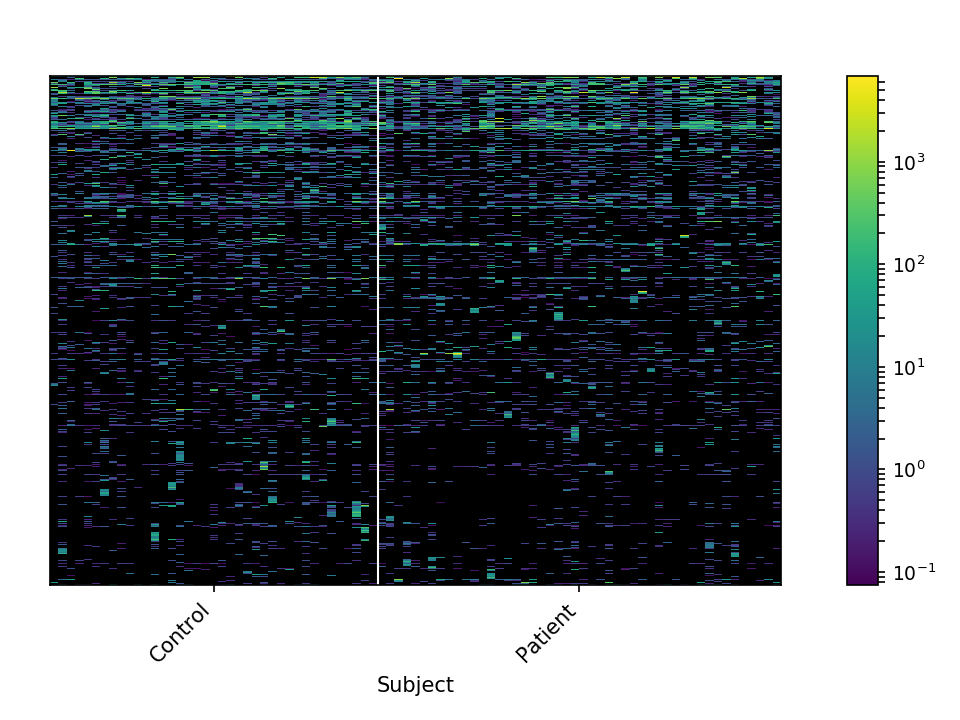

In [11]:
datc.plot(sample_field='Subject', gui='jupyter')

## Now let's add the sex as a bar on top
First we'll also sort by sex, so values will be continuous (note we then sort by the disease state to get the two groups separated).

In [12]:
datc=datc.sort_samples('Sex')
datc=datc.sort_samples('Subject')

<IPython.core.display.Javascript object>


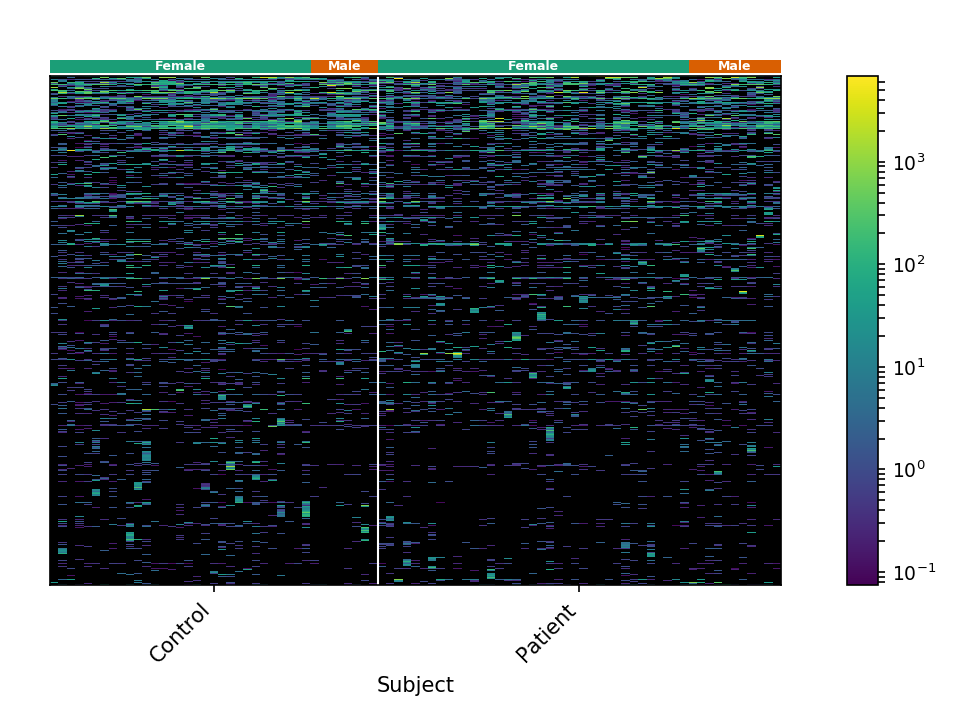

In [13]:
datc.plot(sample_field='Subject', gui='jupyter',barx_fields=['Sex'])

## Now let's look for bacteria separating sick from healthy
We ask it to find all bacteria significantly different between samples with 'Control' and 'Patient' in the 'Subject' field.

By default calour uses the mean of the ranks of each feature (over all samples), with dsFDR multiple hypothesis correction.

For more information, see **notebook** and **function doc**

In [16]:
dd=datc.diff_abundance(field='Subject',val1='Control',val2='Patient')

2018-02-01 10:27:58 INFO 87 samples with both values
2018-02-01 10:27:58 INFO After filtering, 1100 remaining
2018-02-01 10:27:58 INFO 39 samples with value 1 (['Control'])
2018-02-01 10:27:59 INFO method meandiff. number of higher in ['Control'] : 41. number of higher in ['Patient'] : 20. total 61


## And let's plot to see the behavior of these bacteria
The output of diff_abundance is an Experiment with only the significant bacteria, which are sorted by the effect size

<IPython.core.display.Javascript object>


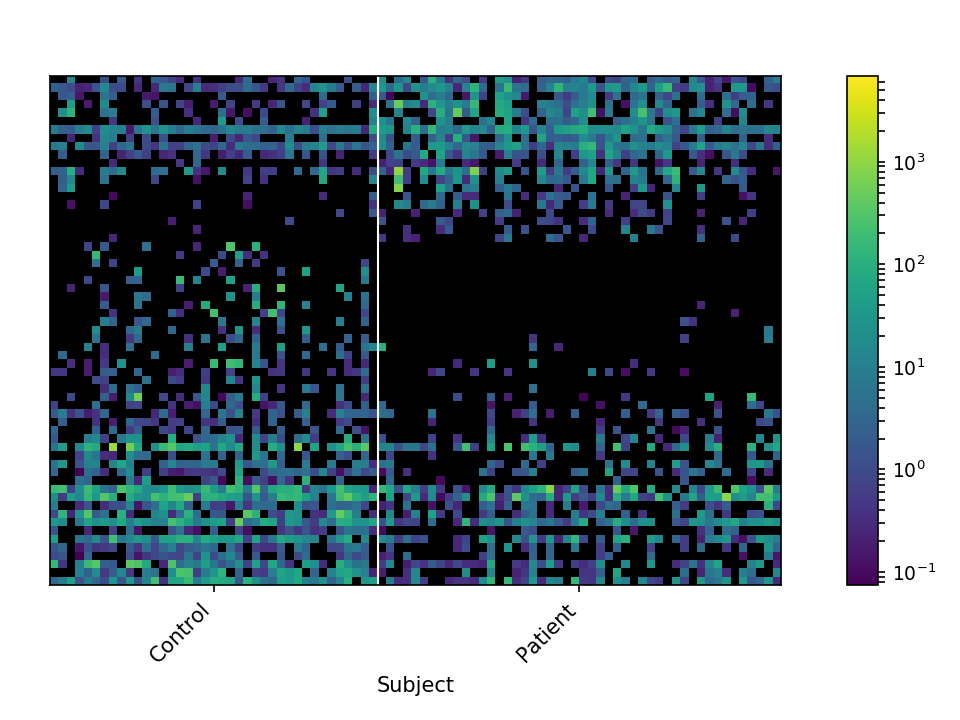

In [17]:
dd.plot(sample_field='Subject', gui='jupyter')

## dbBact term enrichment
We can ask what is special in the bacteria significanly higher in the Control vs. the Patient group and vice versa.

* Note since we need to get the per-feature annotations from dbBact, we need a live internet connection to run this command.

2018-02-01 10:28:06 INFO Getting dbBact annotations for 61 sequences, please wait...
2018-02-01 10:28:10 INFO Got 2077 annotations
2018-02-01 10:28:10 INFO Added annotation data to experiment. Total 722 annotations, 61 terms
2018-02-01 10:28:10 INFO removed 157 terms


<IPython.core.display.Javascript object>


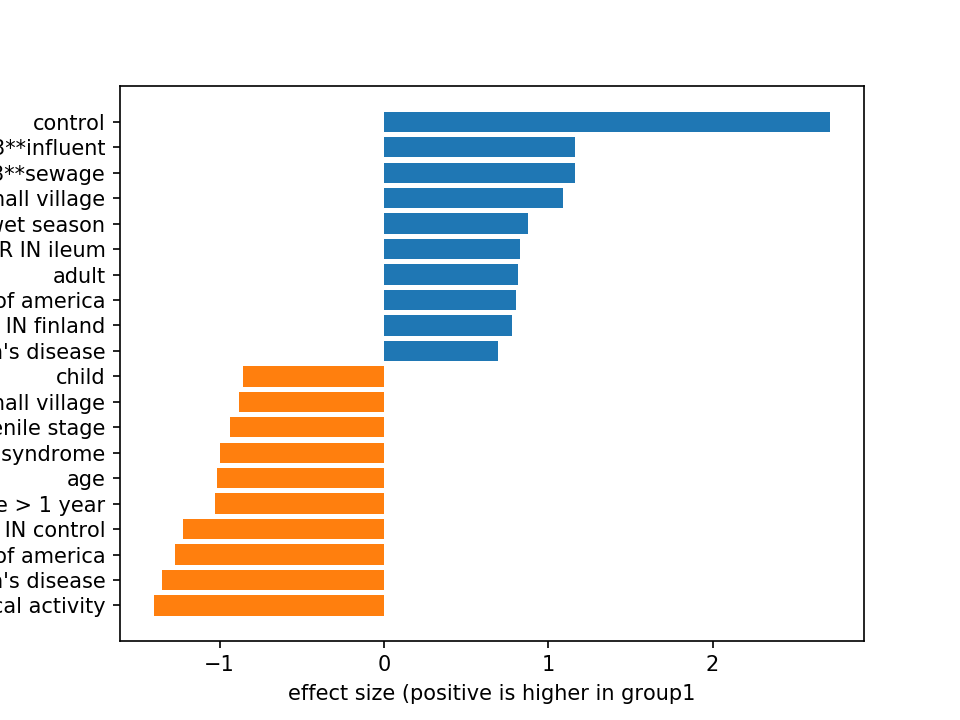

In [18]:
ax, enriched=dd.plot_diff_abundance_enrichment()

The enriched terms are in a calour experiment class (terms are features, bacteria are samples), so we can see the
list of enriched terms with the p-value (pval) and effect size (odif)

In [19]:
enriched.feature_metadata

,odif,pvals,term
**63**little physical activity,-1.400000,0.000999,**63**little physical activity
crohn's disease,-1.351220,0.000999,crohn's disease
united states of america,-1.272579,0.020979,united states of america
-control,-1.223171,0.000999,-control
age > 1 year,-1.026829,0.008991,age > 1 year
age,-1.018348,0.043956,age
**12**chronic fatigue syndrome,-1.000000,0.000999,**12**chronic fatigue syndrome
obsolete_juvenile stage,-0.937602,0.000999,obsolete_juvenile stage
-small village,-0.881707,0.000999,-small village
child,-0.856504,0.004995,child
